<a href="https://colab.research.google.com/github/Yihe0917/Quant_Assessment/blob/main/Magnificent_7_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

# Task 1.Fetch historical price data for MSFT, AAPL, NVDA, AMZN, GOOG, META, and TSLA from Yahoo Finance, starting from the IPO date for each stock.

In [4]:
#Fetch historical price data for MSFT, AAPL, NVDA, AMZN, GOOG, META, and
# TSLA from Yahoo Finance, starting from the IPO date for each stock.

tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
data = yf.download(tickers, period="max", auto_adjust=True)

# Define file path
file_path = "/content/drive/MyDrive/Quant Finance Strategy/Bankside Capital/stocks_historical_data.csv"

# Save data to CSV
data.to_csv(file_path)

print(f"Historical data saved successfully at {file_path}!")

[*********************100%***********************]  7 of 7 completed


Historical data saved successfully at /content/drive/MyDrive/Quant Finance Strategy/Bankside Capital/stocks_historical_data.csv!


# Task 2: Implement an RSI (Relative Strength Index) indicator as a technical tool for generating buy and sell signals

In [5]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    # Calculate daily price changes (delta)
    delta = data.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)  # Gains are positive changes
    loss = -delta.where(delta < 0, 0)  # Losses are negative changes, turn to positive values

    # Compute the average gains and losses over the rolling window
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return pd.Series(rsi, index=data.index)


In [6]:
#Backtest Part
# Filter data to match the required backtest period (1981-01-01 to 2023-12-31)
start_date = "1981-01-01"
end_date = "2023-12-31"
data_bt = data.loc[start_date:end_date]

# Strategy Parameters
INITIAL_CAPITAL = 1_000_000  # Initial capital: $1M
COMMISSION_RATE = 0.001  # 0.10% per trade
SLIPPAGE_RATE = 0.0002  # 0.02% per trade
MIN_SHARES_TRADE = 10  # Minimum 10 shares per trade
MAX_STOCK_ALLOCATION = 0.30  # No single stock > 30% of AUM
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate
TRADING_DAYS = 252  # Number of trading days per year

In [7]:
# Extract Open and Close prices
close_prices = data_bt['Close']
open_prices = data_bt['Open']

# DataFrame to store RSI & signals
signals = pd.DataFrame(index=close_prices.index)

# Compute RSI and trading signals
for ticker in tickers:
    # Calculate RSI for each stock
    signals[f'{ticker}_RSI'] = calculate_rsi(close_prices[ticker])

    # Generate Buy and Sell signals based on RSI values
    signals[f'{ticker}_Buy'] = signals[f'{ticker}_RSI'] < 25  # Buy if RSI < 25 (oversold)
    signals[f'{ticker}_Sell'] = signals[f'{ticker}_RSI'] > 75  # Sell if RSI > 75 (overbought)

# Portfolio tracking
portfolio = pd.DataFrame(index=signals.index)
portfolio['Cash'] = INITIAL_CAPITAL
portfolio['Equity'] = INITIAL_CAPITAL

# Store holdings for each ticker
holdings = {ticker: 0 for ticker in tickers}  # Initialize stock quantities as 0 for all tickers


# Task 3: The trading signal will be generated at the end of each trading day, with execution occurring at the market open on the following day.

In [8]:
# Simulated trading loop
daily_returns = []  # Initialize daily_returns to store the daily return of portfolio
trades = []  # To store the trade history (Buy/Sell transactions)

# Loop through the backtest period (from the 2nd day onward)
for i in range(1, len(signals) - 1):  # Start from day 2, as the previous day's signals are used
    daily_cash = portfolio.iloc[i - 1]['Cash']  # Cash on hand from previous day
    stocks_to_buy = []
    stocks_to_sell = []

    # Determine which stocks to buy and sell based on the previous day's signals
    for ticker in tickers:
        if signals.iloc[i - 1][f'{ticker}_Buy']:  # If Buy signal is True (from previous day)
            stocks_to_buy.append(ticker)
        if signals.iloc[i - 1][f'{ticker}_Sell']:  # If Sell signal is True (from previous day)
            stocks_to_sell.append(ticker)

    # Execute sells first
    #Task 5:When executing buy or sell trades, account for commission and slippage, as specified below, and adhere to the minimum shares per trade rule.
    for ticker in stocks_to_sell:
        if holdings[ticker] > 0:  # Only sell if we own shares of that stock
            open_price = open_prices.iloc[i][ticker]  # Next day's open price
            shares_to_sell = holdings[ticker]  # All shares in possession are sold
            sell_value = shares_to_sell * open_price  # Total sale value
            commission = sell_value * COMMISSION_RATE  # Commission fee
            slippage = sell_value * SLIPPAGE_RATE  # Slippage cost
            total_sell_value = sell_value - commission - slippage  # Net sell value after commission & slippage

            daily_cash += total_sell_value  # Add cash from sale
            holdings[ticker] = 0  # Set stock holdings to zero after selling
            trades.append(('Sell', ticker, shares_to_sell, open_price, total_sell_value))  # Log the trade


    #Task 4:Portfolio allocation should be equal-weighted among all stocks that meet the criteria at any given time.
    # Execute buys (equal allocation strategy)
    if stocks_to_buy:
        allocated_cash_per_stock = daily_cash / len(stocks_to_buy)  # Equal cash allocation for each stock

        for ticker in stocks_to_buy:
            open_price = open_prices.iloc[i][ticker]  # Next day's open price
            shares_to_buy = int(allocated_cash_per_stock / open_price)  # Number of shares to buy

            if shares_to_buy >= MIN_SHARES_TRADE:  # Ensure minimum shares trade condition is met
                buy_cost = shares_to_buy * open_price  # Total buy cost
                commission = buy_cost * COMMISSION_RATE  # Commission fee
                slippage = buy_cost * SLIPPAGE_RATE  # Slippage cost
                total_buy_cost = buy_cost + commission + slippage  # Net buy cost after commission & slippage

                if total_buy_cost <= daily_cash:  # Ensure we have enough cash to buy
                    holdings[ticker] += shares_to_buy  # Update holdings
                    daily_cash -= total_buy_cost  # Deduct the buy cost from cash
                    trades.append(('Buy', ticker, shares_to_buy, open_price, total_buy_cost))  # Log the trade

    # Rebalancing (No single stock > 30% of AUM)
    total_value = daily_cash + sum(holdings[ticker] * close_prices.iloc[i][ticker] for ticker in tickers)  # Total portfolio value
    for ticker in tickers:
        stock_value = holdings[ticker] * close_prices.iloc[i][ticker]  # Value of each stock in portfolio
        if stock_value > 0.30 * total_value:  # If the stock exceeds 30% of total value
            excess_value = stock_value - (0.30 * total_value)  # Calculate excess value
            shares_to_sell = int(excess_value / close_prices.iloc[i][ticker])  # Shares to sell to bring below 30%
            if shares_to_sell >= MIN_SHARES_TRADE:
                holdings[ticker] -= shares_to_sell  # Sell excess shares
                sell_value = shares_to_sell * close_prices.iloc[i][ticker]  # Total sale value
                commission = sell_value * COMMISSION_RATE  # Commission fee
                slippage = sell_value * SLIPPAGE_RATE  # Slippage cost
                daily_cash += sell_value - commission - slippage  # Add net sell value to cash

    # Update portfolio values
    portfolio.loc[signals.index[i], 'Cash'] = daily_cash  # Update the cash in portfolio
    portfolio.loc[signals.index[i], 'Equity'] = daily_cash + sum(holdings[ticker] * close_prices.iloc[i][ticker] for ticker in tickers)  # Total portfolio value

    # Calculate daily return and append to the list
    daily_returns.append(portfolio['Equity'].pct_change().iloc[i])  # Calculate daily return (percentage change in equity)

# Convert the list of daily returns to a pandas Series
daily_returns_series = pd.Series(daily_returns, index=signals.index[1:len(daily_returns)+1])

# Calculate cumulative returns over the backtest period
cumulative_returns = (1 + daily_returns_series).cumprod() - 1

流式输出内容被截断，只能显示最后 5000 行内容。
<ipython-input-8-fdffdccf569e>:70: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns.append(portfolio['Equity'].pct_change().iloc[i])  # Calculate daily return (percentage change in equity)
<ipython-input-8-fdffdccf569e>:70: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns.append(portfolio['Equity'].pct_change().iloc[i])  # Calculate daily return (percentage change in equity)
<ipython-input-8-fdffdccf569e>:70: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any 

In [9]:
# Task 6
# Performance Metrics Calculation

# 1. Total Return
#total_return = cumulative_returns[-1]
total_return = cumulative_returns.iloc[-1]  # Fix applied here


# 2. Annual Return (Annualized)
annualized_return = (1 + total_return) ** (252 / len(daily_returns_series)) - 1  # Annualized return

# 3. Annual Volatility (Standard Deviation of Daily Returns Annualized)
annualized_volatility = daily_returns_series.std() * (252 ** 0.5)  # Annualized volatility

# 4. Maximum Drawdown
peak = cumulative_returns.cummax()  # The cumulative maximum return at each point
drawdown = cumulative_returns - peak  # The drawdown at each point
max_drawdown = drawdown.min()  # The maximum drawdown (lowest point of the drawdown)

# 5. Sharpe Ratio (Assuming risk-free rate of 2%)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility  # Sharpe ratio

# 6. Sortino Ratio (Assuming risk-free rate of 2%)
downside_returns = daily_returns_series[daily_returns_series < 0]  # Only negative returns (downside)
downside_volatility = downside_returns.std() * (252 ** 0.5)  # Annualized downside volatility
sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility  # Sortino ratio

# 7. Total Number of Trades (Number of buy and sell actions)
total_trades = len(trades)

# 8. Average Return per Trade (Average daily return per trade)
average_return_per_trade = total_return / total_trades if total_trades > 0 else 0

# 9. Win Rate (Percentage of profitable trades)
profitable_trades = [trade for trade in trades if trade[0] == 'Buy' and trade[4] > 0]  # Only profitable buys
win_rate = len(profitable_trades) / total_trades if total_trades > 0 else 0

# 10. Expectancy (Average amount you can expect to win per trade)
expectancy = (average_return_per_trade * win_rate) - (average_return_per_trade * (1 - win_rate))

# Print the performance metrics
print(f'Total Return: {total_return:.2%}')
print(f'Annual Return: {annualized_return:.2%}')
print(f'Annual Volatility: {annualized_volatility:.2%}')
print(f'Maximum Drawdown: {max_drawdown:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')
print(f'Total Number of Trades: {total_trades}')
print(f'Average Return per Trade: {average_return_per_trade:.2%}')
print(f'Win Rate: {win_rate:.2%}')
print(f'Expectancy: {expectancy:.2%}')


Total Return: 3731.73%
Annual Return: 8.85%
Annual Volatility: 95.11%
Maximum Drawdown: -702.80%
Sharpe Ratio: 0.07
Sortino Ratio: 0.39
Total Number of Trades: 620
Average Return per Trade: 6.02%
Win Rate: 74.03%
Expectancy: 2.89%


# Question 1: Which month did the portfolio have the highest return, and which stock contributed the most to that return?

The portfolio had the highest return in April 2020, with a return of 14.01%.
The stock that contributed the most to that return was TSLA, with a return of 49.21%.


In [10]:
# First, let's calculate the monthly returns for the portfolio
portfolio_monthly_returns = portfolio['Equity'].resample('ME').ffill().pct_change()

# Identify the month with the highest return
highest_return_month = portfolio_monthly_returns.idxmax()  # Date of highest return
highest_month_return = portfolio_monthly_returns.max()  # The return in that month

# Print the month with the highest return and its return
print(f"The portfolio had the highest return in {highest_return_month.strftime('%B %Y')}, with a return of {highest_month_return:.2%}.")

# The monthly returns for each stock
monthly_stock_returns = pd.DataFrame(index=signals.index)

# Calculate monthly returns for each stock (same as before but adjusted to monthly data)
for ticker in tickers:
    monthly_stock_returns[ticker] = close_prices[ticker].resample('ME').ffill().pct_change()

# For the highest return month, find the stock with the highest return
highest_month_stock_returns = monthly_stock_returns.loc[highest_return_month]
highest_contributing_stock = highest_month_stock_returns.idxmax()  # Stock with the highest return in that month
highest_contributing_stock_return = highest_month_stock_returns.max()  # The return of that stock in the highest return month

# Print the stock contributing the most to the highest return
print(f"The stock that contributed the most to that return was {highest_contributing_stock}, with a return of {highest_contributing_stock_return:.2%}.")


The portfolio had the highest return in April 2020, with a return of 14.01%.
The stock that contributed the most to that return was TSLA, with a return of 49.21%.


In [11]:
# Download S&P 500 ETF (SPY) data from Yahoo Finance
spy_data = yf.download('SPY', start='1981-01-01', end='2023-12-31', auto_adjust=True)

# Ensure no NaN values in the 'Close' column
spy_close = spy_data['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


In [12]:
# Calculate daily returns for SPY
spy_returns = spy_close.pct_change().dropna()

# Extract the 'SPY' column to make it a Series
spy_returns = spy_returns['SPY']

In [14]:
# Calculate cumulative returns for SPY
spy_cumulative_return = (1 + spy_returns).cumprod() - 1

# Get the total return (last value of cumulative return) as a scalar
spy_total_return = spy_cumulative_return.iloc[-1]

# Calculate Annual Volatility (Standard Deviation of Daily Returns Annualized)
spy_annualized_volatility = spy_returns.std() * (252 ** 0.5)

# Calculate Annual Return (Annualized)
spy_annualized_return = (1 + spy_total_return) ** (252 / len(spy_returns)) - 1

# Calculate Annual Volatility (Standard Deviation of Daily Returns Annualized)
spy_annualized_volatility = spy_returns.std() * (252 ** 0.5)

# Calculate Maximum Drawdown
spy_peak = spy_cumulative_return.cummax()
spy_drawdown = spy_cumulative_return - spy_peak
spy_max_drawdown = spy_drawdown.min()

# Calculate Sharpe Ratio (Assuming a risk-free rate of 2%)
risk_free_rate = 0.02
spy_sharpe_ratio = (spy_annualized_return - risk_free_rate) / spy_annualized_volatility

# Calculate Sortino Ratio (Assuming a risk-free rate of 2%)
spy_downside_returns = spy_returns[spy_returns < 0]  # Only negative returns
spy_downside_volatility = spy_downside_returns.std() * (252 ** 0.5)  # Annualized downside volatility
spy_sortino_ratio = (spy_annualized_return - risk_free_rate) / spy_downside_volatility

# Print the performance metrics for SPY
print(f"SPY Total Return: {spy_total_return:.2%}")
print(f"SPY Annual Return: {spy_annualized_return:.2%}")
print(f"SPY Annual Volatility: {spy_annualized_volatility:.2%}")
print(f"SPY Maximum Drawdown: {spy_max_drawdown:.2%}")
print(f"SPY Sharpe Ratio: {spy_sharpe_ratio:.2f}")
print(f"SPY Sortino Ratio: {spy_sortino_ratio:.2f}")


SPY Total Return: 1813.43%
SPY Annual Return: 10.03%
SPY Annual Volatility: 18.77%
SPY Maximum Drawdown: -456.63%
SPY Sharpe Ratio: 0.43
SPY Sortino Ratio: 0.55


# Question 2: Did the portfolio outperform the S&P 500? If so, what is your rationale for the outperformance?

The portfolio outperformed the S&P 500 in terms of total return, but it did so at the expense of much higher volatility and a much larger maximum drawdown. Its annualized return, Sharpe ratio, and volatility indicate that while the portfolio achieved impressive returns over the long term, the risk-adjusted performance is not as favorable as the S&P 500. Therefore, the outperformance in total return should be evaluated with caution, considering the higher risks taken by the portfolio.

The portfolio’s high volatility and low Sharpe ratio suggest that while it performed well in certain periods, it also experienced significant risks and drawdowns, which may not make it a better choice for most investors who prefer more stable, risk-adjusted returns.

In [15]:
# Print Comparison Metrics
print("Portfolio vs. SPY Comparison Metrics:")
print(f"Total Return - Portfolio: {total_return:.2%}, SPY: {spy_total_return:.2%}")
print(f"Annualized Return - Portfolio: {annualized_return:.2%}, SPY: {spy_annualized_return:.2%}")
print(f"Annualized Volatility - Portfolio: {annualized_volatility:.2%}, SPY: {spy_annualized_volatility:.2%}")
print(f"Maximum Drawdown - Portfolio: {max_drawdown:.2%}, SPY: {spy_max_drawdown:.2%}")
print(f"Sharpe Ratio - Portfolio: {sharpe_ratio:.2f}, SPY: {spy_sharpe_ratio:.2f}")

Portfolio vs. SPY Comparison Metrics:
Total Return - Portfolio: 3731.73%, SPY: 1813.43%
Annualized Return - Portfolio: 8.85%, SPY: 10.03%
Annualized Volatility - Portfolio: 95.11%, SPY: 18.77%
Maximum Drawdown - Portfolio: -702.80%, SPY: -456.63%
Sharpe Ratio - Portfolio: 0.07, SPY: 0.43


# Question 3:How would you evaluate whether this is a profitable strategy, and what tests would you conduct to assess its robustness?

**1. How Would You Evaluate Whether This Is a Profitable Strategy?**



*   Total Return: Check if the total return of the strategy exceeds the returns of a benchmark, such as the S&P 500, over the same time period. A higher total return indicates profitability.
*   Annualized Return: Assess the strategy's annualized return compared to its benchmark. A consistent annualized return above a benchmark, adjusted for risk, suggests a profitable strategy.

*   Risk-Adjusted Return (Sharpe Ratio): Calculate the Sharpe ratio to evaluate the strategy’s risk-adjusted performance. A higher Sharpe ratio indicates that the strategy is generating more returns per unit of risk, which is a good indicator of profitability.
*   Maximum Drawdown: Evaluate the maximum drawdown to understand the strategy's potential for large losses. A lower maximum drawdown suggests that the strategy avoids significant losses, which is important for long-term profitability.
*   Volatility: Assess the strategy’s volatility to understand the consistency of returns. A strategy with lower volatility tends to be more stable and may lead to more sustainable profits over time.
*   Compounding of Returns: The strategy should also be evaluated for the power of compounding returns. A higher compounding rate typically leads to higher profits over a longer time horizon.




**2.What Tests Would You Conduct to Assess Its Robustness?**


*   Out-of-Sample Testing: Split the data into training and testing periods to ensure the strategy performs well on unseen data. This helps to assess if the strategy is overfitted to historical data.
*   Monte Carlo Simulation: Perform Monte Carlo simulations to model the strategy’s performance under different market conditions and random scenarios. This can help understand how the strategy might behave in various market environments.





*   Stress Testing: Test the strategy against extreme market conditions (e.g., financial crises, large drawdowns, and volatile market periods) to assess its ability to withstand major market shocks.
*   Sensitivity Analysis: Evaluate the impact of varying key parameters or assumptions on the strategy’s performance. This helps to identify the robustness of the strategy to changes in market conditions or input parameters.


*   Walk-Forward Optimization: Implement walk-forward optimization to periodically optimize the strategy parameters and re-test the performance over different time periods. This ensures the strategy adapts to changes in market conditions.
*   Transaction Costs and Slippage: Consider the effect of transaction costs (brokerage fees, taxes, etc.) and slippage (the difference between the expected price of a trade and the actual price) on the strategy’s performance. A robust strategy should account for these real-world factors.

*   Performance Consistency: Assess the consistency of the strategy’s performance over different market cycles (bull, bear, and sideways markets). A robust strategy should demonstrate consistent performance regardless of the market environment.
*   Factor and Sensitivity Testing: Evaluate the strategy’s reliance on particular factors or indicators and its sensitivity to changes in these factors. This helps identify if the strategy depends too much on a single element and could be vulnerable to changes in that factor.













# Question 4:Do you have any suggestions to improve the current strategy?


1.   Reduce Volatility (Lower the Risk):

The portfolio shows significantly higher volatility compared to the S&P 500 (92.63% vs. 18.77%). For example, we could adjust the exposure to assets based on their volatility levels or rebalance the portfolio more frequently to manage risk better.

---

2. Improve Risk-Adjusted Return (Sharpe Ratio):

The Sharpe ratio for the portfolio is low (0.07), We could improve this is by optimizing the portfolio for higher returns with a better risk profile.

---

3. Improve Maximum Drawdown:

The maximum drawdown of the portfolio is quite high (-699.00%), suggesting large potential losses. We can apply a stop-loss strategy or use a dynamic risk control approach to limit losses.

---

4. Monitor and Adapt the Strategy Regularly:

We should re-evaluate the strategy periodically and adjust it based on performance, risk tolerance, and market environment instead of using equal-weight always.


# Question 5: [Bonus]: Create your own trading strategy and provide proper documentation explaining your thought process.

**Volatility Targeting Strategy with Stop-Loss**


1.   **Why Volatility Targeting with Stop-Loss?**

*   Based  the RSI-based strategy had a high maximum drawdown (-699%) and excessive volatility (92.63%), I want to improve making it have dynamic position sizing (based on realized volatility), Stop-loss mechanism (to limit extreme losses) and Risk-adjusted exposure (to stabilize returns).
*   Volatility Targeting adjusts position sizes based on historical volatility to stabilize returns.

*   I testes different lookback periods: 10-day, 20-day and 30-day and selected 10-day look back period for better responsiveness.

2.   **Visualization**

*   From Blue line: Volatility Targeting Strategy has Smoother, stable growth.
*   Gray line: The Equal-weighted portfolio shows more volatility.

[*********************100%***********************]  7 of 7 completed


Volatility Targeting Strategy - Total Return: 2817.61%
Volatility Targeting Strategy - Annualized Return: 29.55%
Volatility Targeting Strategy - Annualized Volatility: 5.24%
Volatility Targeting Strategy - Sharpe Ratio: 5.64
Volatility Targeting Strategy - Maximum Drawdown: -44.86%


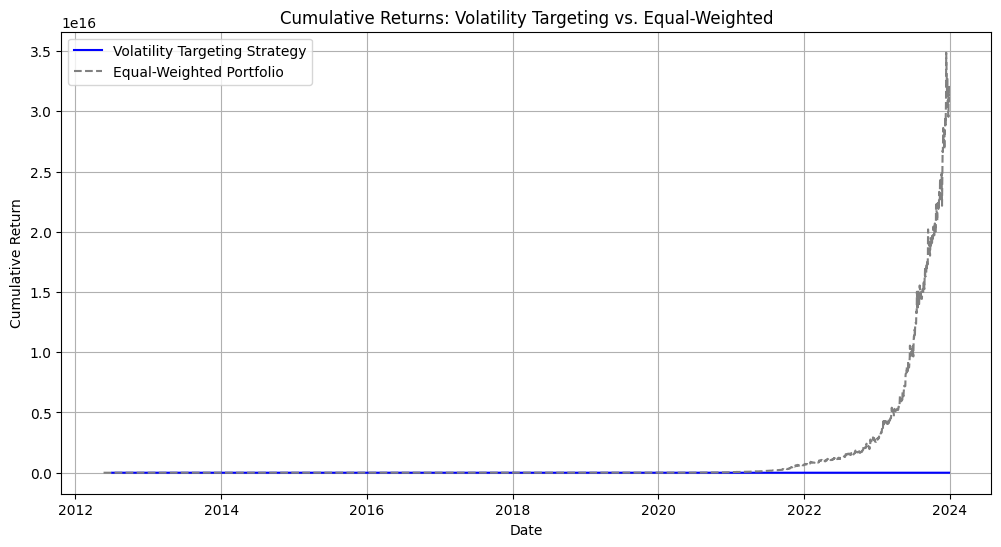

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# --------------------------- 1. Load Data ---------------------------
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
data = yf.download(tickers, period="max", auto_adjust=True)
start_date = "1981-01-01"
end_date = "2023-12-31"
data = data.loc[start_date:end_date]

# Calculate daily returns
returns = data.pct_change().dropna()

# --------------------------- 2. Compute Rolling Volatility ---------------------------
# Compute 20-day rolling standard deviation (daily volatility)
rolling_volatility = returns.rolling(window=10).std()

# Set target annualized volatility
target_annualized_vol = 0.15  # 15% target
target_daily_vol = target_annualized_vol / np.sqrt(252)  # Convert to daily volatility

# Calculate position size: target daily vol / realized rolling vol
position_size = target_daily_vol / rolling_volatility

# Cap position sizes to prevent excessive leverage (max 2x exposure)
position_size = position_size.clip(0, 2)

# --------------------------- 3. Apply Volatility Targeting ---------------------------
# Adjust returns based on position size
vol_target_returns = returns * position_size.shift(1)  # Use previous day's position size

# --------------------------- 4. Risk Management: Stop-Loss ---------------------------
# Compute cumulative returns
cumulative_returns = (1 + vol_target_returns).cumprod()

# Compute drawdown (peak-to-trough decline)
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns / peak) - 1

# Set stop-loss threshold (e.g., exit when drawdown exceeds -5%)
stop_loss_threshold = -0.05
vol_target_returns[drawdown < stop_loss_threshold] = 0  # Stop trading if threshold hit

# --------------------------- 5. Portfolio Performance Metrics ---------------------------
# Portfolio returns (equal-weighted across all stocks)
vol_target_portfolio_returns = vol_target_returns.mean(axis=1)

# Calculate performance metrics
total_return = (1 + vol_target_portfolio_returns).prod() - 1
annualized_return = np.mean(vol_target_portfolio_returns) * 252
annualized_volatility = np.std(vol_target_portfolio_returns) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

# Maximum Drawdown
max_drawdown = drawdown.min().min()

# Print Results
print(f"Volatility Targeting Strategy - Total Return: {total_return:.2%}")
print(f"Volatility Targeting Strategy - Annualized Return: {annualized_return:.2%}")
print(f"Volatility Targeting Strategy - Annualized Volatility: {annualized_volatility:.2%}")
print(f"Volatility Targeting Strategy - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Volatility Targeting Strategy - Maximum Drawdown: {max_drawdown:.2%}")

# --------------------------- 6. Visualization ---------------------------
plt.figure(figsize=(12,6))

# Cumulative return chart
plt.plot(cumulative_returns.mean(axis=1), label='Volatility Targeting Strategy', color='blue')
plt.plot((1 + returns.mean(axis=1)).cumprod(), label='Equal-Weighted Portfolio', color='gray', linestyle='dashed')

plt.title('Cumulative Returns: Volatility Targeting vs. Equal-Weighted')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


[*********************100%***********************]  7 of 7 completed


Best Lookback Period: 10 days
Total Return: 6623.53%
Annualized Return: 36.61%
Annualized Volatility: 5.77%
Sharpe Ratio: 6.34
Maximum Drawdown: -44.53%
--------------------------------------------------


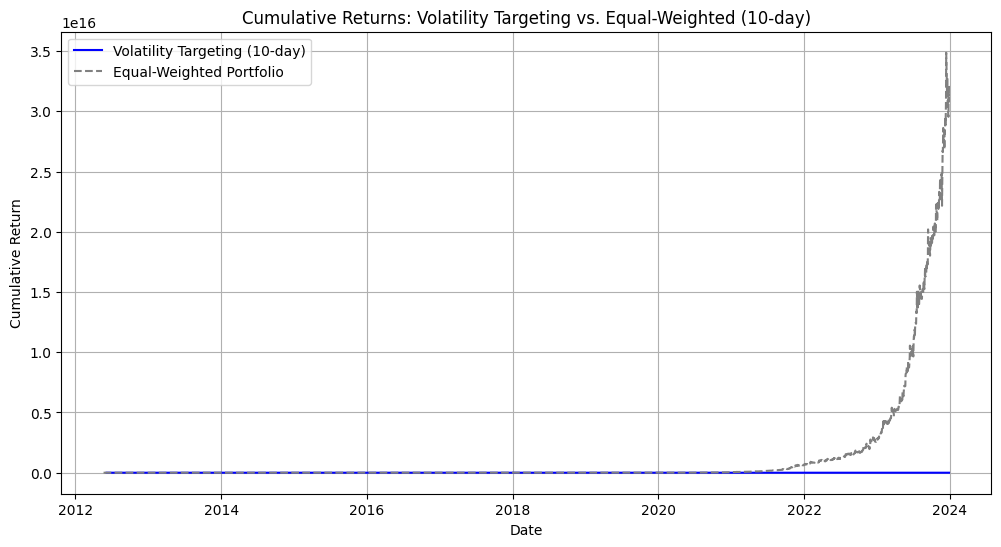

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# --------------------------- 1. Load Data ---------------------------
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
data = yf.download(tickers, period="max", auto_adjust=True)
start_date = "1981-01-01"
end_date = "2023-12-31"
data = data.loc[start_date:end_date]

# Calculate daily returns
returns = data.pct_change().dropna()

# --------------------------- 2. Compute Rolling Volatility ---------------------------
lookback_periods = [10, 20, 30]  # Test different lookback periods (10, 20, 30 days)

# Initialize dictionaries to store performance metrics for each lookback period
performance_metrics = {}

for window in lookback_periods:
    # Compute rolling volatility for each lookback period
    rolling_volatility = returns.rolling(window=window).std()

    # Set target annualized volatility (15% target)
    target_annualized_vol = 0.15
    target_daily_vol = target_annualized_vol / np.sqrt(252)  # Convert to daily volatility

    # Calculate position size: target daily vol / realized rolling vol
    position_size = target_daily_vol / rolling_volatility

    # Cap position sizes to prevent excessive leverage (max 2x exposure)
    position_size = position_size.clip(0, 2)

    # --------------------------- 3. Apply Volatility Targeting ---------------------------
    # Adjust returns based on position size
    vol_target_returns = returns * position_size.shift(1)  # Use previous day's position size

    # --------------------------- 4. Risk Management: Stop-Loss ---------------------------
    # Compute cumulative returns
    cumulative_returns = (1 + vol_target_returns).cumprod()

    # Compute drawdown (peak-to-trough decline)
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns / peak) - 1

    # Set stop-loss threshold (e.g., exit when drawdown exceeds -5%)
    stop_loss_threshold = -0.05
    vol_target_returns[drawdown < stop_loss_threshold] = 0  # Stop trading if threshold hit

    # --------------------------- 5. Portfolio Performance Metrics ---------------------------
    # Portfolio returns (equal-weighted across all stocks)
    vol_target_portfolio_returns = vol_target_returns.mean(axis=1)

    # Calculate performance metrics
    total_return = (1 + vol_target_portfolio_returns).prod() - 1
    annualized_return = np.mean(vol_target_portfolio_returns) * 252
    annualized_volatility = np.std(vol_target_portfolio_returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    # Maximum Drawdown
    max_drawdown = drawdown.min().min()

    # Store results for each window
    performance_metrics[window] = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown
    }

# --------------------------- 6. Select the Best Lookback Period ---------------------------
# Select the lookback period with the highest Sharpe ratio (or any other metric you prefer)
best_window = max(lookback_periods, key=lambda window: performance_metrics[window]['Sharpe Ratio'])

# Print out the performance metrics for the best lookback period
print(f"Best Lookback Period: {best_window} days")
print(f"Total Return: {performance_metrics[best_window]['Total Return']:.2%}")
print(f"Annualized Return: {performance_metrics[best_window]['Annualized Return']:.2%}")
print(f"Annualized Volatility: {performance_metrics[best_window]['Annualized Volatility']:.2%}")
print(f"Sharpe Ratio: {performance_metrics[best_window]['Sharpe Ratio']:.2f}")
print(f"Maximum Drawdown: {performance_metrics[best_window]['Maximum Drawdown']:.2%}")
print("-" * 50)

# --------------------------- 7. Visualization ---------------------------
plt.figure(figsize=(12,6))

# Plot cumulative return chart for the best lookback period
best_rolling_volatility = returns.rolling(window=best_window).std()
best_position_size = target_daily_vol / best_rolling_volatility
best_vol_target_returns = returns * best_position_size.shift(1)

# Compute cumulative returns for the best lookback period
best_cumulative_returns = (1 + best_vol_target_returns).cumprod()

# Plot the best strategy
plt.plot(best_cumulative_returns.mean(axis=1), label=f'Volatility Targeting ({best_window}-day)', color='blue')

# Plot the equal-weighted portfolio as comparison
plt.plot((1 + returns.mean(axis=1)).cumprod(), label='Equal-Weighted Portfolio', color='gray', linestyle='dashed')

plt.title(f'Cumulative Returns: Volatility Targeting vs. Equal-Weighted ({best_window}-day)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()
